## Experimenting with Dropout Layers

The following notebook highlights the work that was done to explore the different ways to incorporating dropout layers into our DenseNet model. In an effort to reduce the generalizable error, a dropout layer in our CNN model will drop nodes in the network with probability equal to the pre-set dropout rate. This notebook also explores with varying dropout rates. 

**NOTE:** This notebook was run on Kaggle with the GPU Accelator Enabled. The data used for this notebook is available on the MDS-Capstone-GDLR OneDrive. You can find the data used in this notebook by navigating to the Data Processed Ultrasound directory and downloading the data_split_mapped sub-directory.

### Imports

In [1]:
pwd

'/kaggle/working'

In [2]:
!pip install -U albumentations

     |████████████████████████████████| 98 kB 1.1 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


In [3]:
import torch
import numpy as np
import pandas as pd
import os


from torchvision import models, datasets, utils#,transforms
from collections import OrderedDict

from torch import nn, optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

In [4]:
torch.manual_seed(2020)
dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data

In [5]:
IMAGE_SIZE = 300
BATCH_SIZE = 8
TRAIN_DIR = "../input/lipodata3/data_split_unmapped_v2/train"
VALID_DIR = "../input/lipodata3/data_split_unmapped_v2/val"

train_transforms = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(0, 1.0)),
        A.VerticalFlip(),
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        ToTensorV2(),
        
    ])

valid_transforms = A.Compose([
        A.Resize(height = 300, width = 300),
        ToTensorV2(),
        
    ])

In [6]:
class LipoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        
        # Create a list of filepaths of images and the respective label
        self.samples = []

        for i in os.listdir(root_dir):
            if i in ["positive", 'negative']:
                folder = os.path.join(root_dir, i)
                target = folder.split("/")[-1]
                for label in os.listdir(folder):
                    filepath = os.path.join(folder, label)
                    self.samples.append((target, filepath))


    def __len__(self):
        # Get the length of the samples 
        return len(self.samples)

    def __getitem__(self, index):
        # Implement logic to get an image and its label using the received index.
        #
        # `image` should be a NumPy array with the shape [height, width, num_channels].
        # If an image contains three color channels, it should use an RGB color scheme.
        #
        # `label` should be an integer in the range [0, model.num_classes - 1] where `model.num_classes`
        # is a value set in the `search.yaml` file.
        
        # get the filepath of the image based on the index and convert it to 
        # color scale and then into a numpy array
        image = np.array(Image.open(self.samples[index][1]).convert("RGB"))

        # maps a label to an integer value
        label_to_int = {"positive": 1, "negative": 0}
        label = label_to_int[self.samples[index][0]]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
            image = image/255

        return image, label

In [7]:
# test if the above class works and outputs the appropriate info
if __name__ == '__main__':
    dataset = LipoDataset(TRAIN_DIR)
    print(len(dataset))
    print(dataset[0][0].shape)

246
(385, 429, 3)


In [8]:
# create a dataset and tranform the images 
dataset = LipoDataset(TRAIN_DIR, transform=train_transforms)
v_dataset = LipoDataset(VALID_DIR, transform=valid_transforms)

# create a dataloader 
train_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(v_dataset, batch_size=8)

img, label = next(iter(train_loader))
img.shape

torch.Size([8, 3, 300, 300])

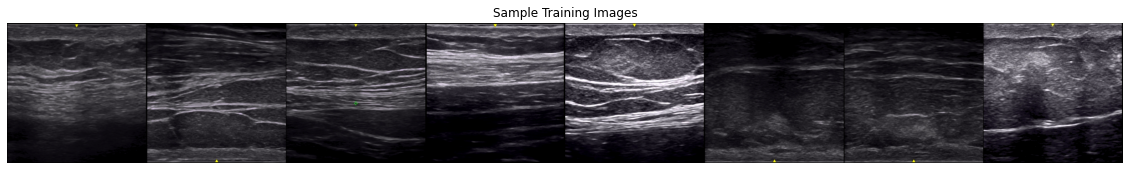

In [9]:
import matplotlib.pyplot as plt
# plot the samples
plt.figure(figsize=(20, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(img, padding=1),(1, 2, 0)));

## Training Functions

In [10]:
def weights_init(m, verbose = False):
    """Initialize weights of each layer to make the results more reproducible"""
    if isinstance(m, nn.Conv2d):
        if verbose:
            print("Initializing weights of a Conv2d layer!")
        nn.init.normal_(m.weight, mean=0, std=0.1)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d): 
        if verbose:        
            print("Initializing weights of a batchnorm layer!")
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        if verbose:
            print("Initializing weights of a Linear layer!")
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

In [11]:
def train(model, train_loader, hyperparameters, epochs=20):
    """Training wrapper for PyTorch network."""

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=hyperparameters.get("lr", 0.001),
                           betas=(hyperparameters.get("beta1", 0.9), 0.999))
    for epoch in range(epochs):
        for X, y in train_loader:
            if device.type == 'cuda':
                X, y = X.to(device, torch.float32), y.to(device, torch.float32)
            optimizer.zero_grad()
            y_hat = model(X).flatten()
            loss = criterion(y_hat, y.type(torch.float32))
            loss.backward()
            optimizer.step()
    
    return model

In [12]:
def evaluate(model, valid_loader):
    """Validation wrapper for PyTorch network."""
    
    model.eval()
    accuracy = 0
    with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
        for X, y in valid_loader:
            if device.type == 'cuda':
                X, y = X.to(device, torch.float32), y.to(device, torch.float32)
            y_hat = model(X).flatten()
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            accuracy += (y_hat_labels == y).type(torch.float32).sum().item()
    accuracy /= len(valid_loader.dataset)  # avg accuracy
    print(f"Validation accuracy: {accuracy:.4f}")
    
    return accuracy 

## Optimized Hyperparamters

In [13]:
best_parameters = {'lr': 7.456370422609558e-05, 'beta1': 0.9815918038692326}

## Training Function

In [14]:
def make_model(dropout=False, drop_init=False, rate=0.2):
    
    if dropout == True:
        if drop_init == True:
            densenet = models.densenet121(pretrained=True, drop_rate=rate)
            new_layers = torch.nn.Sequential(OrderedDict([
           ('new1', torch.nn.Linear(1024, 500)),
           ('dropout1', torch.nn.Dropout(rate)),
           ('relu', torch.nn.ReLU()),
           ('dropout2', torch.nn.Dropout(rate)),
           ('new2', torch.nn.Linear(500, 1))]))
        else: 
                densenet = models.densenet121(pretrained=True, drop_rate=rate)
                new_layers = torch.nn.Sequential(OrderedDict([
                    ('new1', torch.nn.Linear(1024, 500)),
                    ('relu', torch.nn.ReLU()),
                    ('new2', torch.nn.Linear(500, 1))
                ]))
    else: 
                densenet = models.densenet121(pretrained=True)
                new_layers = torch.nn.Sequential(OrderedDict([
                    ('new1', torch.nn.Linear(1024, 500)),
                    ('relu', torch.nn.ReLU()),
                    ('new2', torch.nn.Linear(500, 1))
                ]))
        
        
    densenet.classifier = new_layers
    torch.manual_seed(2020)
    densenet.apply(weights_init);
    
    return densenet

## Testing Functions

In [15]:
def pytorch_confusion_matrix(cnn, data_loader):
    """return confusion matrix on a holdout sample for a pytorch cnn model(binary classification)"""
    confusion_matrix = torch.zeros(2, 2)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    cnn.eval()
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(data_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = cnn(inputs).flatten()
            preds = torch.sigmoid(outputs) > 0.5
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    cm = pd.DataFrame(confusion_matrix.numpy(), columns = ['predict negative','predict positive'], index = ['actual negative', 'actual positive'])
    return cm

def recall_calculation(confusion_matrix):
    """return recall of holdout sample from a confusion matrix"""
    test_recall = confusion_matrix.iloc[1,1]/(confusion_matrix.iloc[1,1]+confusion_matrix.iloc[1,0])
    print(f"Test recall is {test_recall*100:.2f}%.")
    return test_recall

def get_test_accuracy(cnn, data_loader):
    """return accuracy on a holdout sample for a pytorch cnn model"""
    test_batch_acc = 0
    cnn.eval()
    with torch.no_grad():
        for X, y in data_loader:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            if device.type == 'cuda':
                X, y = X.to(device), y.to(device)
            y_hat = cnn(X).flatten()
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            test_batch_acc += (y_hat_labels == y).type(torch.float32).sum().item()
    test_accuracy = test_batch_acc / len(data_loader.dataset)
    print(f"Test accuracy is {test_accuracy*100:.2f}%.")
    return test_accuracy

## Training & Testing

In [16]:
TEST_DIR = "../input/lipodata3/data_split_unmapped_v2/test"
test_dataset = LipoDataset(TEST_DIR, transform=valid_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [17]:
criterion = nn.BCEWithLogitsLoss()
betas = (best_parameters["beta1"], 0.999)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
model_nodrop = make_model()
model_3drop = make_model(dropout=True, drop_init=True, rate=0.1)
model_inbit = make_model(dropout=True, drop_init=False, rate=0.2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_nodrop.to(device)
model_3drop.to(device)
model_inbit.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [19]:
optimizer = torch.optim.Adam(model_nodrop.parameters(),
                                lr = best_parameters["lr"],
                                betas = betas)

model_nodrop = train(model_nodrop, train_loader, hyperparameters=best_parameters, epochs=25)

In [20]:
optimizer = torch.optim.Adam(model_3drop.parameters(),
                                lr = best_parameters["lr"],
                                betas = betas)

model_3drop = train(model_3drop, train_loader, hyperparameters=best_parameters, epochs=25)

In [21]:
optimizer = torch.optim.Adam(model_inbit.parameters(),
                                lr = best_parameters["lr"],
                                betas = betas)

model_inbit = train(model_inbit, train_loader, hyperparameters=best_parameters, epochs=25)

## Test Accuracy

In [22]:
get_test_accuracy(model_nodrop, test_loader)

Test accuracy is 62.96%.


0.6296296296296297

In [23]:
get_test_accuracy(model_3drop, test_loader)

Test accuracy is 70.37%.


0.7037037037037037

In [24]:
get_test_accuracy(model_inbit, test_loader)

Test accuracy is 62.96%.


0.6296296296296297

## Confusion Matrix

In [25]:
pytorch_confusion_matrix(model_nodrop, test_loader)

,predict negative,predict positive
actual negative,25.0,8.0
actual positive,12.0,9.0


In [26]:
pytorch_confusion_matrix(model_3drop, test_loader)

,predict negative,predict positive
actual negative,31.0,2.0
actual positive,14.0,7.0


In [27]:
pytorch_confusion_matrix(model_inbit, test_loader)

,predict negative,predict positive
actual negative,31.0,2.0
actual positive,18.0,3.0


## Recall Evaluation

In [28]:
recall_calculation(pytorch_confusion_matrix(model_nodrop, test_loader))

Test recall is 42.86%.


0.42857143

In [29]:
recall_calculation(pytorch_confusion_matrix(model_3drop, test_loader))

Test recall is 33.33%.


0.33333334

In [30]:
recall_calculation(pytorch_confusion_matrix(model_inbit, test_loader))

Test recall is 14.29%.


0.14285715

## Save Models

In [31]:
torch.save(model_nodrop.state_dict(), 'model_nodrop.pth')

In [32]:
torch.save(model_3drop.state_dict(), 'model_3drop.pth')

In [33]:
torch.save(model_inbit.state_dict(), 'model_inbit.pth')